In [1]:
# import pandas module 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# making dataframe 
answers_df = pd.read_csv("./Answers.csv", encoding = "ISO-8859-1") 
questions_df = pd.read_csv("./Questions.csv", encoding = "ISO-8859-1")
tags_df = pd.read_csv("./Tags.csv", encoding = "ISO-8859-1")

In [3]:
answers_df.head(5)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [4]:
questions_df.head(5)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [5]:
# initial EDA, data cleaning
# 1) look at distribution of scores on the answers
# --- join to questions ---
# distribution of max answer score for each question
# distribution of # responses per question

In [6]:
scores = answers_df['Score']

{'whiskers': [<matplotlib.lines.Line2D at 0x7f57c8705c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f57c86a51f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f57c8705940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f57c86a5790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f57c86a5a60>],
 'means': []}

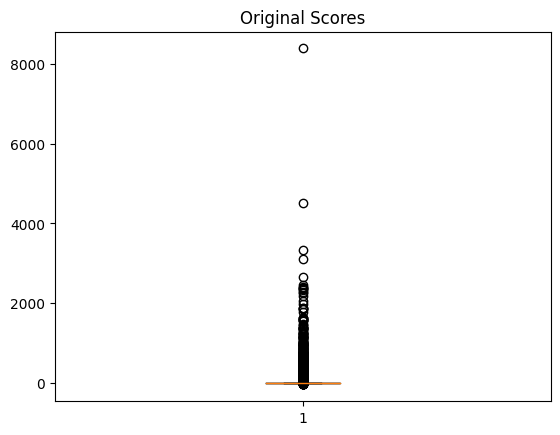

In [7]:
# an initial look at the scores makes it clear that there are some very extreme values...
fig1, ax1 = plt.subplots()
ax1.set_title('Original Scores')
ax1.boxplot(scores)

In [8]:
# median is 1, 75% is 3, but the max is 8384. let's see where it all goes wrong
scores.describe()

count    987122.000000
mean          3.028437
std          21.263246
min         -38.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        8384.000000
Name: Score, dtype: float64

In [9]:
# using the IQR method to remove outliers. Instead of removing, will just replace with the limit
# IE) Scores greater than upper_limit will just be replaced with upper limit, same with lower limit.
# https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce

In [10]:
IQR = scores.quantile(0.75) - scores.quantile(0.25)
print(IQR)

3.0


In [11]:
scores_upper_limit = scores.quantile(0.75) + 3 * IQR
scores_lower_limit = scores.quantile(0.25) - 3 * IQR

In [12]:
answers_df[answers_df['Score'] > scores_upper_limit] = scores_upper_limit
answers_df[answers_df['Score'] < scores_lower_limit] = scores_lower_limit

{'whiskers': [<matplotlib.lines.Line2D at 0x7f57c65ff940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f57c65ffdc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f57c65ff670>],
 'medians': [<matplotlib.lines.Line2D at 0x7f57c66073a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f57c6607670>],
 'means': []}

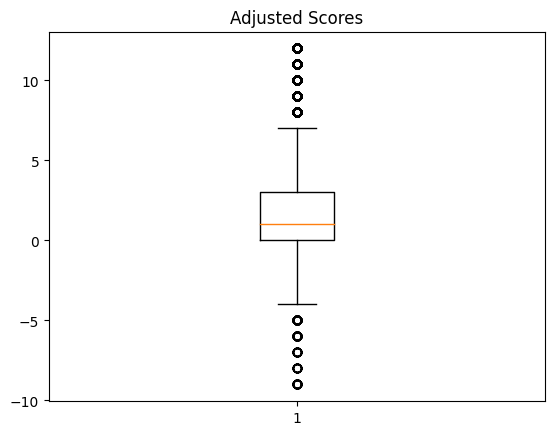

In [13]:
fig1, ax1 = plt.subplots()
ax1.set_title('Adjusted Scores')
ax1.boxplot(scores)

array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

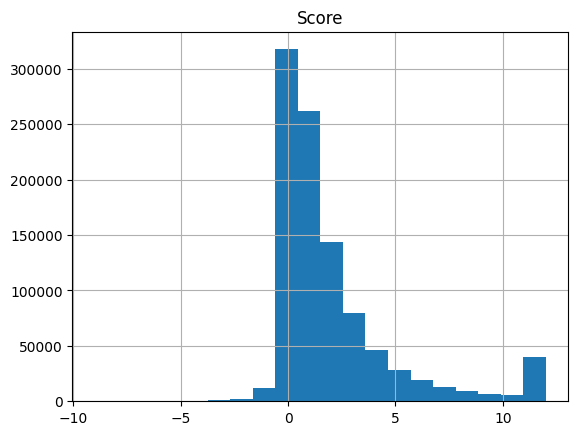

In [14]:
# Histogram view of the general distribution of the Score trait, among the answers
answers_df.hist(column="Score", bins=20)

In [15]:
# utility function, to just get the slice of the answers_df which matches the question ID
def get_question_answer_info(question_id):
    relevant_answers = answers_df.query(f"ParentId == {question_id}")
    scores = relevant_answers['Score']
    num_answers = len(scores)
    highest_score = np.max(scores)
    if num_answers == 0:
        highest_score = 0

    return highest_score, num_answers

In [16]:
# first insert empty columns, which we will rewrite shortly
questions_df.insert(6, "highest_answer_score", 0)
questions_df.insert(7, "num_answers", 0)

In [17]:
index = questions_df.index
for row_index in index:
    if row_index % 200000 == 0:
        print(row_index)
    question = questions_df.loc[row_index]
    question_id = question['Id']
    highest_score, num_answers = get_question_answer_info(question_id)
    questions_df.loc[row_index, ['highest_answer_score']] = highest_score
    questions_df.loc[row_index, ['num_answers']] = num_answers

0
200000
400000
600000


In [18]:
questions_df

,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,4,3
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,4,1
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,8,7
...,...,...,...,...,...,...,...,...
607277,40143190,333403.0,2016-10-19T23:36:01Z,1,How to execute multiline python code from a ba...,<p>I need to extend a shell script (bash). As ...,5,2
607278,40143228,6662462.0,2016-10-19T23:40:00Z,0,How to get google reCaptcha image source using...,<p>I understood that reCaptcha loads a new fra...,0,0
607279,40143267,4064680.0,2016-10-19T23:44:07Z,0,Updating an ManyToMany field with Django rest,<p>I'm trying to set up this API so I can use ...,0,0
607280,40143338,7044980.0,2016-10-19T23:52:27Z,2,Most possible pairs,"<p>Given a list of values, and information on ...",0,0


In [19]:
questions_df.to_csv("processed_questions.csv") # basically the raw data, but with highest_answer_score as well as num_answers

array([[<AxesSubplot:title={'center':'highest_answer_score'}>]],
      dtype=object)

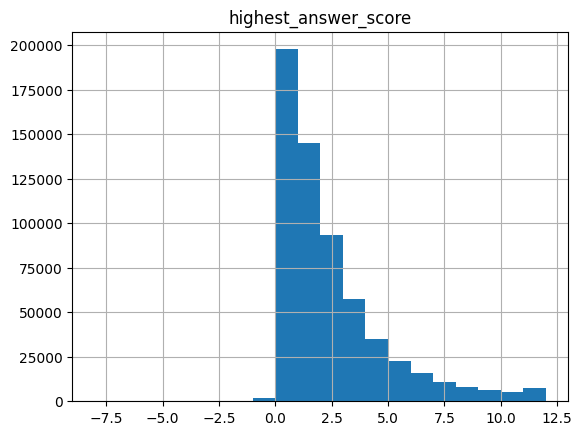

In [20]:
questions_df.hist(column="highest_answer_score", bins=20)

array([[<AxesSubplot:title={'center':'num_answers'}>]], dtype=object)

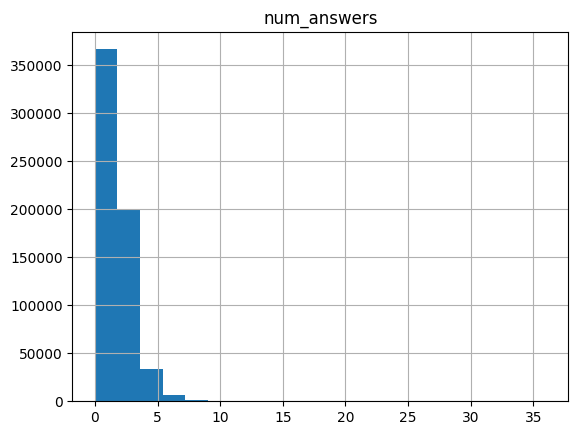

In [21]:
questions_df.hist(column="num_answers", bins=20)